# Implimentation of a small "Wide ResNet"
Based on a lecture by [Fawaz Sammani](https://github.com/fawazsammani)

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
from trainers import ClassifierTrainer
from wide_resnet import make_resnet_architecture, BasicBlock, WideResnet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import random

In [2]:
class CIFARDataset(Dataset):

    def __init__(self,path,filenames,transform=None):
        self.data_dict = self.load_data(path,filenames)
        self.class_names = self.unpickle(os.path.join(path,'batches.meta'))[b'label_names']
        self.class_names = list(map(lambda x: x.decode('UTF-8'), self.class_names))
        self.images = self.data_dict[b'data'].reshape(-1,3,32,32)
        self.labels = self.data_dict[b'labels']
        self.transform = transform
        
    def __getitem__(self,index):
        # Get one item from the dataset
        sample = self.images[index]
        if self.transform:
            img = Image.fromarray(sample.T)
            sample = np.asanyarray(self.transform(img))
            sample = sample.T
        sample = sample/255
        label = self.labels[index]
        sample = torch.tensor(sample).float()
        label = torch.tensor(label)
        return sample, label
    
    def __len__(self):
        return len(self.images)
    
    def load_data(self,path,filenames):
        data_dict = {}
        for filename in filenames:
            batch_dict = self.unpickle(os.path.join(path_data,filename))
            if len(data_dict)==0:
                data_dict = batch_dict
            else:
                data_dict[b'labels'] += batch_dict[b'labels']  
                data_dict[b'data'] = np.vstack((data_dict[b'data'],batch_dict[b'data']))
        return data_dict
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
def show_sample_image(dataset, idx=0, add_title=True, ax=None):
    image, label = dataset[idx]
    label = int(label.item())
    image = image.numpy().T
    flipped_image = np.zeros(image.shape)
    flipped_image[:,:, 0] = image[:,:, 0].T
    flipped_image[:,:, 1] = image[:,:, 1].T
    flipped_image[:,:, 2] = image[:,:, 2].T
    label_name = dataset.class_names[label]
    if ax is None:
        _, ax = plt.subplots(figsize=(1,1))
    ax.imshow(flipped_image, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    if add_title:
        ax.set_title(label_name)
    return flipped_image, label, label_name, ax

# Setup the datasets

In [4]:
path_data = './data/cifar-10-batches-py/'
batchfiles = os.listdir(path_data)
train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_batches = ['test_batch']

batch_size = 100

### Data Augmentation

In [5]:
#transforms = Tr.AutoAugment(Tr.AutoAugmentPolicy.CIFAR10)
transforms = Tr.Compose([Tr.Pad(4),
                         Tr.RandomHorizontalFlip(),
                         Tr.RandomCrop(32)])


In [6]:
train_dataset = CIFARDataset(path_data, train_batches, transform=transforms)
test_dataset = CIFARDataset(path_data, test_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

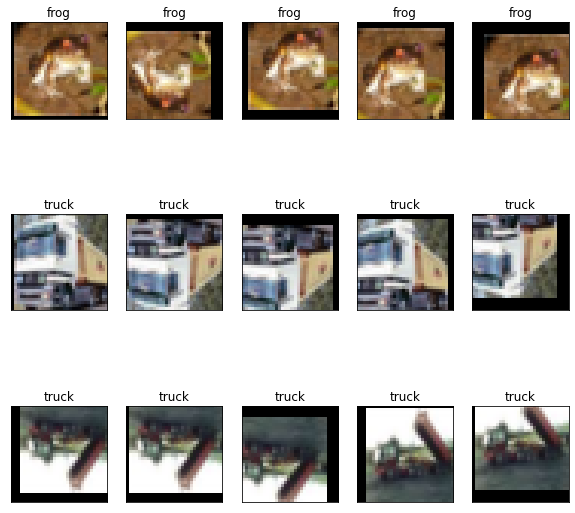

In [7]:
dataset = train_dataset

nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))


for i in range(nrows):
    for j in range(ncols):
        image, _, _, ax = show_sample_image(dataset, i,ax=axs[i,j], add_title=True)
    

# Train the mdel

**ResNet architecture with k=1**

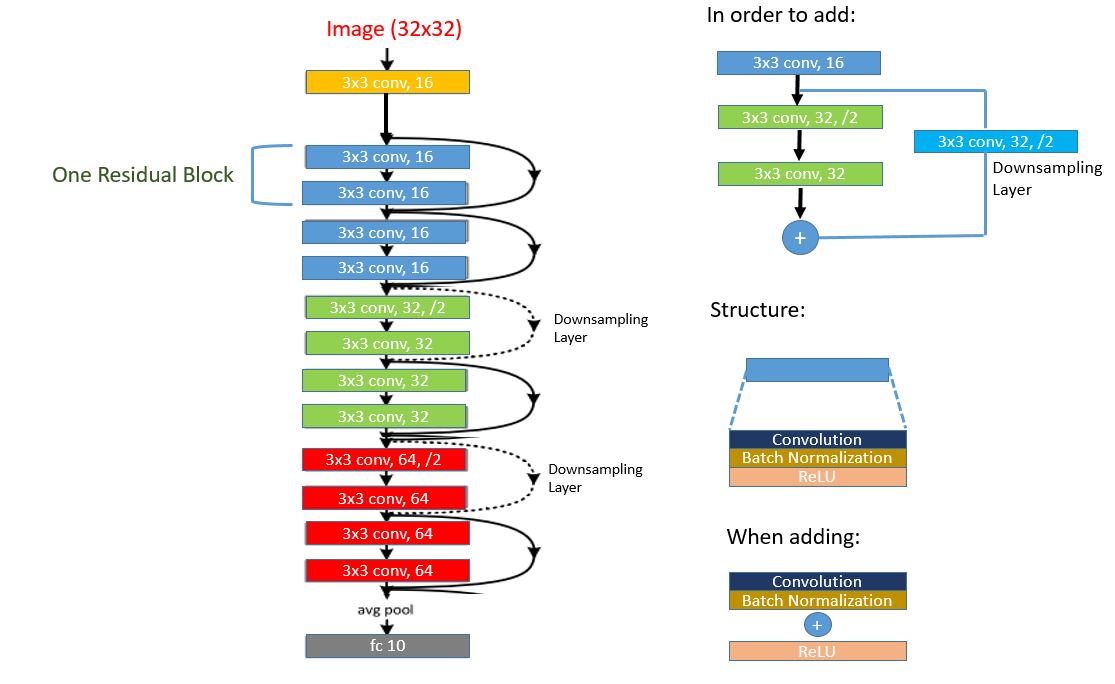

In [8]:
# Make model architecture
architecture = make_resnet_architecture(k=3)

In [9]:
#Learning rate
learning_rate = learning_rate = 0.001
#Number of pochs
num_epochs = 100
#Initialize the model
model = WideResnet(architecture, BasicBlock)
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Create a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [10]:
trainer = ClassifierTrainer(model, optimizer,
                            train_loader, test_loader, scheduler)

In [11]:
%%time
trainer.fit(num_epochs)

Epoch 1/100, Training Loss: 1.516, Training Accuracy: 0.435, Testing Loss: 1.387, Testing Acc: 0.503
Epoch 2/100, Training Loss: 1.149, Training Accuracy: 0.586, Testing Loss: 1.082, Testing Acc: 0.614
Epoch 3/100, Training Loss: 0.989, Training Accuracy: 0.647, Testing Loss: 1.068, Testing Acc: 0.630
Epoch 4/100, Training Loss: 0.886, Training Accuracy: 0.685, Testing Loss: 1.014, Testing Acc: 0.655
Epoch 5/100, Training Loss: 0.805, Training Accuracy: 0.714, Testing Loss: 0.886, Testing Acc: 0.697
Epoch 6/100, Training Loss: 0.741, Training Accuracy: 0.740, Testing Loss: 0.741, Testing Acc: 0.740
Epoch 7/100, Training Loss: 0.691, Training Accuracy: 0.756, Testing Loss: 0.797, Testing Acc: 0.719
Epoch 8/100, Training Loss: 0.646, Training Accuracy: 0.772, Testing Loss: 0.727, Testing Acc: 0.747
Epoch 9/100, Training Loss: 0.604, Training Accuracy: 0.787, Testing Loss: 0.710, Testing Acc: 0.756
Epoch 10/100, Training Loss: 0.570, Training Accuracy: 0.800, Testing Loss: 0.631, Testing 

Epoch 82/100, Training Loss: 0.077, Training Accuracy: 0.972, Testing Loss: 0.693, Testing Acc: 0.853
Epoch 83/100, Training Loss: 0.079, Training Accuracy: 0.972, Testing Loss: 0.661, Testing Acc: 0.858
Epoch 84/100, Training Loss: 0.080, Training Accuracy: 0.972, Testing Loss: 0.669, Testing Acc: 0.857
Epoch 85/100, Training Loss: 0.075, Training Accuracy: 0.973, Testing Loss: 0.658, Testing Acc: 0.859
Epoch 86/100, Training Loss: 0.076, Training Accuracy: 0.973, Testing Loss: 0.671, Testing Acc: 0.860
Epoch 87/100, Training Loss: 0.071, Training Accuracy: 0.974, Testing Loss: 0.661, Testing Acc: 0.862
Epoch 88/100, Training Loss: 0.075, Training Accuracy: 0.973, Testing Loss: 0.659, Testing Acc: 0.864
Epoch 89/100, Training Loss: 0.071, Training Accuracy: 0.975, Testing Loss: 0.641, Testing Acc: 0.863
Epoch 90/100, Training Loss: 0.070, Training Accuracy: 0.975, Testing Loss: 0.664, Testing Acc: 0.858
Epoch 91/100, Training Loss: 0.068, Training Accuracy: 0.975, Testing Loss: 0.682,

In [12]:
model_file = './models/cifar10_miniwrn_v2_110922'
trainer.save_model(model_file)

# Model Evaluation

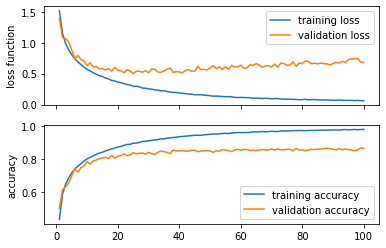

In [13]:
epochs = list(range(1,num_epochs+1))

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(epochs, trainer.train_losses)
axs[0].plot(epochs, trainer.test_losses)
axs[0].set_ylabel('loss function')
axs[0].legend(['training loss', 'validation loss'])
axs[1].plot(epochs, trainer.train_accuracies)
axs[1].plot(epochs, trainer.test_accuracies)
axs[1].set_ylabel('accuracy')
axs[1].legend(['training accuracy', 'validation accuracy'])

# Visualize predictions

accuracy for the presented 25 images: 0.88


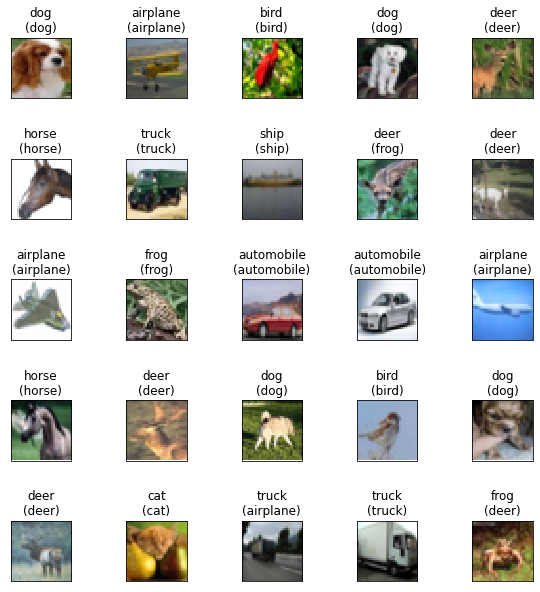

In [14]:
dataset = test_dataset

nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))

accuracy = 0

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(dataset)-1)
        prediction = trainer.predict(dataset, idx)
        prediction_name = dataset.class_names[prediction]
        _, label, label_name, ax = show_sample_image(dataset, idx,ax=axs[i,j], add_title=False)
        ax.set_title(label_name + '\n(' + prediction_name +')')
        plt.subplots_adjust(hspace=1)
        accuracy +=1/(nrows*ncols)*float(prediction==label)
        
print('accuracy for the presented '+str(nrows*ncols)+' images: '+str(round(accuracy,2)))